In [221]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

train_data = pd.read_csv('dataset/price_data_tr.csv')
heldout_data = pd.read_csv('dataset/price_data_val.csv')
test_data = pd.read_csv('dataset/price_data_ts.csv')

In [222]:
#print(train_data.shape) #(12968, 21)
#print(heldout_data.shape) #(4323, 21)
#print(test_data.shape) #(4322, 21)

# data.columns
# 'id', 'date', 
# 'price', 
# 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'

In [223]:
# 최신 연도로 바꾸고 기존 yr_bult, yr_renovated 삭제
train_data['yr_max'] = np.maximum(np.array(train_data.yr_built), np.array(train_data.yr_renovated))
heldout_data['yr_max'] = np.maximum(np.array(heldout_data.yr_built), np.array(heldout_data.yr_renovated))
test_data['yr_max'] = np.maximum(np.array(test_data.yr_built), np.array(test_data.yr_renovated))

train_data = train_data.drop(['yr_built','yr_renovated'], axis=1)
heldout_data = heldout_data.drop(['yr_built','yr_renovated'], axis=1)
test_data = test_data.drop(['yr_built','yr_renovated'], axis=1)

In [224]:
# log sqft_lot
train_data['sqft_lot'] = np.log(train_data['sqft_lot'])
heldout_data['sqft_lot'] = np.log(heldout_data['sqft_lot'])
test_data['sqft_lot'] = np.log(test_data['sqft_lot'])
# log sqft_lot15
train_data['sqft_lot15'] = np.log(train_data['sqft_lot15'])
heldout_data['sqft_lot15'] = np.log(heldout_data['sqft_lot15'])
test_data['sqft_lot15'] = np.log(test_data['sqft_lot15'])
# drop zipcode
# train_data = train_data.drop(['zipcode'], axis=1)
# heldout_data = heldout_data.drop(['zipcode'], axis=1)
# test_data = test_data.drop(['zipcode'], axis=1)

# -zipcode
train_data['zipcode'] = -train_data['zipcode']
heldout_data['zipcode'] = -heldout_data['zipcode']
test_data['zipcode'] = -test_data['zipcode']

# test
train_data['sqft_living15'] = np.log(train_data['sqft_living15'])
heldout_data['sqft_living15'] = np.log(heldout_data['sqft_living15'])
test_data['sqft_living15'] = np.log(test_data['sqft_living15'])
train_data['sqft_above'] = np.log(train_data['sqft_above'])
heldout_data['sqft_above'] = np.log(heldout_data['sqft_above'])
test_data['sqft_above'] = np.log(test_data['sqft_above'])
train_data['sqft_living'] = np.log(train_data['sqft_living'])
heldout_data['sqft_living'] = np.log(heldout_data['sqft_living'])
test_data['sqft_living'] = np.log(test_data['sqft_living'])

In [225]:
nor_train = train_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / (x.std()))
nor_heldout = heldout_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / (x.std()))
nor_test = test_data.iloc[:, 3:].apply(lambda x: (x-x.mean()) / (x.std()))

nor_log_train_price = np.log(train_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / (x.std()))
nor_log_heldout_price = np.log(heldout_data.iloc[:, 2:3]).apply(lambda x: (x-x.mean()) / (x.std()))

In [226]:
train_log_label_mean, train_log_label_std = np.log(train_data.iloc[:, 2]).mean(), np.log(train_data.iloc[:, 2]).std()
heldout_log_label_mean, heldout_log_label_std = np.log(heldout_data.iloc[:, 2]).mean(), np.log(heldout_data.iloc[:, 2]).std()
print(train_log_label_mean, train_log_label_std)
print(heldout_log_label_mean, heldout_log_label_std)

uni_log_label_mean = np.log(pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2]))).mean()
uni_log_label_std = np.log(pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2]))).std()
print(uni_log_label_mean, uni_log_label_std)

13.04810655020148 0.5220080959315785
13.048257499579405 0.5355929705203868
13.048144289728448 0.5254218546587482


In [227]:
train_feats = torch.tensor(nor_train.iloc[:, :].values, dtype=torch.float32)
heldout_feats = torch.tensor(nor_heldout.iloc[:, :].values, dtype=torch.float32)
test_feat = torch.tensor(nor_test.iloc[:, :].values, dtype=torch.float32)

train_labels = torch.tensor(nor_log_train_price.values.reshape(-1, 1), dtype=torch.float32)
heldout_labels = torch.tensor(nor_log_heldout_price.values.reshape(-1, 1), dtype=torch.float32)

In [228]:
n_train, in_features = train_data.shape[0], train_feats.shape[1]


class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(in_features, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 256)
        self.fc5 = nn.Linear(256, 128)
        self.fc6 = nn.Linear(128, 64)
        self.fc7 = nn.Linear(64, 32)
        self.fc8 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.dropout(self.relu(self.fc4(x)))
        x = self.dropout(self.relu(self.fc5(x)))
        x = self.dropout(self.relu(self.fc6(x)))
        x = self.relu(self.fc7(x))
        x = self.fc8(x)
        return x
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [229]:
learning_rate = 0.001
weight_decay = 0.1
batch_size = 1024
epochs = 3000

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Regressor().to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200,300,400,500,600,800,1000,1200,1400,1600,1800,2000,2300,2600,2900], gamma=0.85)

epoch: 200 -- train_rmse: 0.38231, train_rmse: 0.38231
epoch: 400 -- train_rmse: 0.36804, train_rmse: 0.36804
epoch: 600 -- train_rmse: 0.35916, train_rmse: 0.35916
epoch: 800 -- train_rmse: 0.35323, train_rmse: 0.35323
epoch: 1000 -- train_rmse: 0.34366, train_rmse: 0.34366
epoch: 1200 -- train_rmse: 0.33854, train_rmse: 0.33854
epoch: 1400 -- train_rmse: 0.33626, train_rmse: 0.33626
epoch: 1600 -- train_rmse: 0.33394, train_rmse: 0.33394
epoch: 1800 -- train_rmse: 0.33218, train_rmse: 0.33218
epoch: 2000 -- train_rmse: 0.33078, train_rmse: 0.33078
epoch: 2200 -- train_rmse: 0.32702, train_rmse: 0.32702
epoch: 2400 -- train_rmse: 0.32730, train_rmse: 0.32730
epoch: 2600 -- train_rmse: 0.32629, train_rmse: 0.32629
epoch: 2800 -- train_rmse: 0.32649, train_rmse: 0.32649
epoch: 3000 -- train_rmse: 0.32644, train_rmse: 0.32644


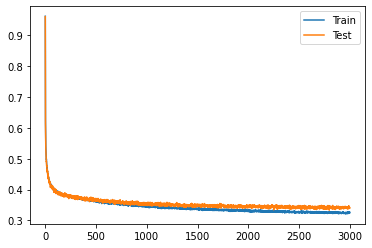

0.3264, 0.3395


In [230]:
train_features, train_labels = train_feats.to(device), train_labels.to(device)
test_features, test_labels = heldout_feats.to(device), heldout_labels.to(device)

dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

train_ls, test_ls = [], []

for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    train_rmse = np.sqrt(criterion(net(train_features), train_labels).item())
    test_rmse = np.sqrt(criterion(net(test_features), test_labels).item())
    
    train_ls.append(train_rmse)
    test_ls.append(test_rmse)
    
    if (epoch + 1) % 200 == 0:
        print(f'epoch: {epoch + 1} -- train_rmse: {train_rmse:.5f}, train_rmse: {test_rmse:.5f}')
    
    
plt.plot(train_ls, label="Train")
plt.plot(test_ls, label="Test")
plt.legend()
plt.show()

print(f'{train_ls[-1]:0.4f}, {test_ls[-1]:0.4f}')

In [231]:
trains = []
helds = []
unis = []

print(train_log_label_std, train_log_label_mean)
print(heldout_log_label_std, heldout_log_label_mean)
print(uni_log_label_std, uni_log_label_mean)

for i in range(3000):
    predicts = net(test_features).to('cpu').detach().numpy()

    train_predicts = np.exp(predicts * train_log_label_std + train_log_label_mean)
    held_predicts = np.exp(predicts * heldout_log_label_std + heldout_log_label_mean)
    uni_predicts = np.exp(predicts * uni_log_label_std + uni_log_label_mean)
        
    rmse_train = rmse(train_predicts, heldout_data.iloc[:, [2]].values)
    rmse_held = rmse(held_predicts, heldout_data.iloc[:, [2]].values)
    rmse_uni = rmse(uni_predicts, heldout_data.iloc[:, [2]].values)
    rmse_other = rmse(other_predicts, heldout_data.iloc[:, [2]].values)
    
    trains.append(rmse_train)
    helds.append(rmse_held)
    unis.append(rmse_uni)

print(np.array(trains).mean())
print(np.array(helds).mean())
print(np.array(unis).mean())

finals = []

for i in range(3000):
    test_predicts = net(test_feat.to('cuda')).cpu().detach().numpy()
    final_predict = np.exp(test_predicts * train_log_label_std + train_log_label_mean)
    finals.append(final_predict)
np.array(finals).mean(axis = 0)

# 134904.32192449123
# 135957.890039547
# 134974.77365882287

0.5220080959315785 13.04810655020148
0.5355929705203868 13.048257499579405
0.5254218546587482 13.048144289728448
137289.19081689735
139129.61374641847
137548.87011795526


array([[664021.1 ],
       [470061.8 ],
       [215077.72],
       ...,
       [868462.5 ],
       [532460.56],
       [414461.7 ]], dtype=float32)

In [207]:
test_data = pd.read_csv('dataset/price_data_ts.csv')
test_data['price'] = np.array(finals).mean(axis = 0)

test_data['id'] = test_data['id'].apply(lambda x : str(x) if len(str(x)) == 10 else '0' + str(x) if len(str(x)) == 9 else '00' + str(x))
test_data['id'] = test_data['id'].astype(str) + test_data['date'].astype(str)
submission = pd.concat([test_data['id'], test_data['price']], axis=1)
submission

,id,price
0,700010085020140926T000000,752229.125000
1,403740028020140923T000000,460574.625000
2,142340016020140618T000000,210307.546875
3,776740006020141119T000000,470847.781250
4,946590050020140617T000000,612893.187500
...,...,...
4317,733822037020141006T000000,313035.062500
4318,681910015020140721T000000,629949.937500
4319,082405914020140527T000000,952596.625000
4320,051450009020140513T000000,542852.500000


In [208]:
submission.to_csv('submission1.csv', index=False)